# Algo trading :execute order now or  rest this order within the Bid/Offer spread for a period time ?
**Kefei Liu (kl3295) <br>
Jiangguangyu Xue (jx1021)**

**Goal:**
The purpose of this project is to find out if an order should be immediately executed by paying (half) the Bid/Offer spread or it would be economically better to rest this order withing the Bid/Offer spread for a period time to achieve possibly a better execution.


# 1. Introduction

In this project,we test different execution approaches to find the best strategy in acquiring best Excution PnL.
There are three approaches:
- **Market Taking (MT)**
- **Opportunity Market Taking Mid(OMMMid)**
- **Opportunity Market Taking Side (OMMSide)** 

MT here is serving like a baseline model, a benchmark that always get negative half of ask-bid spread, While OMMMid's and OMMSide's execution PnL will vary according to market flow. We also try to explore the relations between several parameters in the model and execution PnL, which includes **max Time to Execution (TTE)** and **max Stop Loss (SL)**. What's more, we are eager to find out whether there will be difference in our strategy selection in term of **different alpha engine**.


# 2. Getting data and having a brief look

We are given two CSV Sheets to start with. After we import the these two files, let's have a brief look at the ask-bid data and the order data.

### 1) Market ask and bid prices
For **Market Ask Bid** time series, we want to see the spread in different time periods. However, the data set is quite large, we will just plot the first 9000 quotations of the market to have a brief understanding about the spread and ask-bid prices.

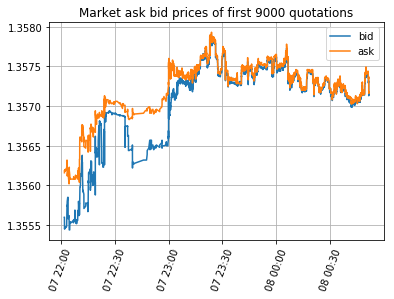

In [37]:
figure_ask_bid

We can find from the graph above that the spread is quite wide during mid night but siginificantly narrow in the morning. 

Also, we have a look at the **spread distribution** before implement the strategies.

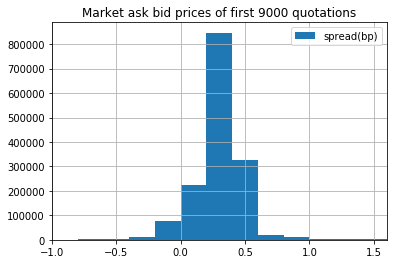

In [38]:
figure_spread

Suprisingly, we find some of the spreads even nagetive. The median of spread is less than half of a bp and around 0.4bp. These information can be very helpful when we implement the model later, since we need to setup approperiate max Stop Loss (SL) for the model.

### 2) order time and buy/sell numbers
We look at the number of buy or sell orders and also the notional of the order in different time.

In terms of the order types, we have 208 sell orders and 162 buy orders. In other words, the sell orders are more than buy orders.

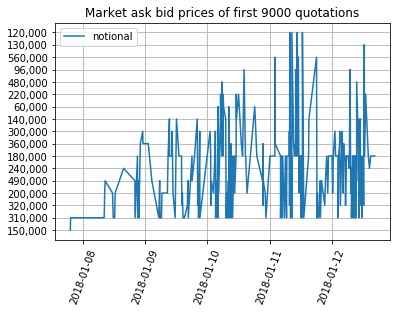

In [39]:
figure_notional

What's more, there are more orders in the last three days and the volume is going up as time goes by.

# 3. Comparison of three different strategies

At first, we initialize our parameters as following: <br>max Time to Execution(TTE) is 10 seconds, max Stop Loss(SL) is 0.0003.

### 1) Mean, median and min of three strategies
After calculation of execution times and prices, we can see that for all approaches,we lost money because mean PnLs are negative. OMMmid and OMMside lose less than half of the start spread, but OMMmid and OMMside strategies work worse than MT strategy.

In [40]:
stats_.iloc[:,0:3].round(3)

,mean PnL(bp),median PnL(bp),min PnL(bp)
MT,-0.021,-0.10,-2.5
OMMmid,-0.150,-0.15,-2.5
OMMside,-0.037,-0.00,-2.8


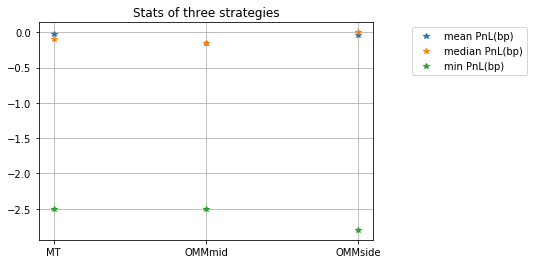

In [41]:
fig1

What's more, we can see that OMMmid approach is the worst strategy and all strategies will loss money with all order executed .

### 2) Sum of PnL, triggered condition of three strategies
We list the sum of PnL of the three strategies and also dive into analyze when the orders are excuted.

In [42]:
stats

,sum PnL(bp)
MT,-7.65
OMMmid,-55.50
OMMside,-13.65


In OMMmid approach, orders marked as SL triggered are most, which means most orders are executed at a worse price than start mid price and thus loss money. In OMMside approach, most orders are executed at SL and 116 orders are executed at end meet price which is less than that of OMMmid because end_meet_price trigger has a larger interval compared to OMMmid approach.

In [43]:
stop_type_number_OMMmid

SL triggered      174
end_meet_price    146
TTE triggered      49
Name: End condition, dtype: int64

In [44]:
stop_type_number_OMMside

SL triggered      183
end_meet_price    116
TTE triggered      70
Name: End condition, dtype: int64

### 3) Sensitivity to TTE
From the anlysis above, we can see that TTE might be small for this case. We want to give a series of TTE to see how the two stratgies react to the change of TTE.

When max Stop Loss(SL) is stable(0.005)(we pick a large Stop Loss, so we can only focus on TTE), as TTE increasing, the means of both strategies are going up.OMMside is a better strategy when we give a TTE that is long enough because it can earn more money than OMMmid strategy.

What's more, OMMside and OMMmid have about the same sensitivity to TTE.


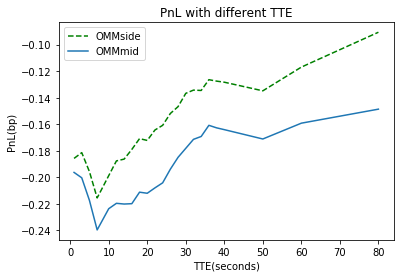

In [74]:
fig2

For a safety choice, we will pick `TTE = 50` here.

### 4) Sensitivity to Stop Loss

We picked TTE = 50 seconds, and try to find the relations between Stop Loss and PnL.

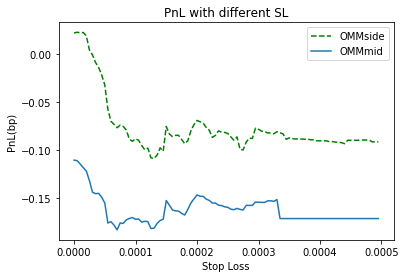

In [79]:
fig4

We can again find from graph above that OMMSide beats OMMMid all time and execution PnL goes down as SL goes up. And if we pick SL=0.00002, OMMside will beat MT(MT has a mean PnL of -0.02). OMMMid will never beat MT.

However, when we are doing this, we might have `overfitting risk`.

### 5) Different alpha engines

We can see from the above anlysis that OMMside is a better choice than OMMmid with TTE = 50 and SL = 0.00002. We will go on our exploration about the aphla engines with these parameters.

In [96]:
alpha_.round(4)

,PnL_OMMside(bp) median,PnL_OMMside(bp) mean,PnL_OMMmid(bp) median,PnL_OMMmid(bp) mean
Alpha,,,,
DIS,0.05,-0.0267,-0.10,-0.1175
MAR,0.05,-0.0127,-0.05,-0.0831
SOM,0.15,0.0356,-0.10,-0.1320


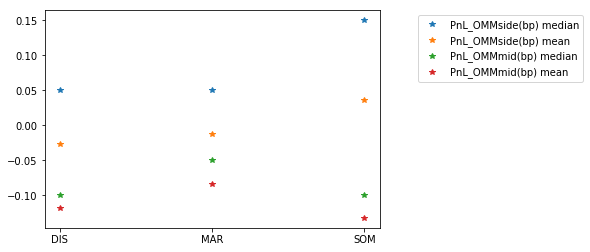

In [97]:
fig3

As we can see from the graphes above:
- For SOM, OMMSide is abtter choice and it can bring positive execution PnL.
- For MAR, mean PnL of OMMSide(-0.0127) is slightly higher than MT(-0.021), but median PnL is much better. We will choose OMMSide too.
- For DIS, mean PnL of OMMSide is worse than MT, so we will choose MT here.

# 4. Conclusion

1. OMMMid performs worse than the other two strategies given any TTE and SL.
2. If we pick TTE aroungd 50 seconds and SL around 2bp, OMMSide will beat MT in both mean and median of PnL.
3. With approperiate SL and TTE in last conclusion, we recommend OMMSide for MAR and SOM and MT for DIS.


# 5. Coding part
Below is our coding part, there are some comments and explainations step by step in our coding part, which introduces how excatly we design our algorithms in details.

# Data input

In [56]:
import pandas as pd
import os
import sys
import matplotlib.pyplot as plt
import numpy as np
import datetime
import time
import math

In [57]:
ba=pd.read_csv('2.csv',encoding='utf-16-le',index_col=0)#read csv in utf-16
ba.head()

,Bid,Ask
DateTime,,
01/07/2018 22:02:03.832,1.35560,1.35616
01/07/2018 22:02:03.845,1.35560,1.35617
01/07/2018 22:02:03.851,1.35554,1.35617
01/07/2018 22:02:03.859,1.35554,1.35618
01/07/2018 22:02:04.114,1.35554,1.35619


In [58]:
order = pd.read_csv("Assignment#3_Orders.csv")
order.head()

,trade_id,buy/sell,notional,executed_price,order_datetime,instrument,alpha
0,107414,1,"150,000",1.35724,1/7/2018 19:07:49.749,GBP/USD,SOM
1,107427,1,"310,000",1.35725,1/7/2018 19:15:23.1523,GBP/USD,SOM
2,107638,-1,"310,000",1.35453,1/8/2018 7:38:48.3848,GBP/USD,SOM
3,107649,-1,"310,000",1.35371,1/8/2018 8:10:55.1055,GBP/USD,SOM
4,107654,-1,"320,000",1.35394,1/8/2018 8:19:10.1910,GBP/USD,SOM


# Approaches introduction

First of all, we import price-time data and data of orders and decide the execution times of each order.

#### In market taking approach, we agress the market immediately and therefore incur the (half) Bid/Offer spread.

#### In Opportunistic Market Making approach, we have two strategies.

**The first is OMMSide, in this part, we go through every quotations after the order time in the following 10 seconds(max Time to Execution)for each order. Then we decide whether the order should be executed at each step following the rule below:**

1)For 'buy' order:

If ask price at the step is smaller than or equals to bid price at the start time, we execute the order and mark it as "end_meet_price". 

If ask price at the step minus start mid price is larger than max stop loss, we should execute to aviod larger loss and mark the order as "SL triggered".

If the order is not executed until the end time, we execute it at the end and mark the order as "TTE triggered". All orders are executed at the ask price.

2)For 'sell' order:

If bid price at the step is bigger than or equals to ask price at the start time, we execute the order and mark it as "end_meet_price". 

If start mid price minus bid price is larger than max stop loss, we should execute to aviod larger loss and mark the order as "SL triggered".

If the order is not executed until the end time, we execute it at the end and mark the order as "TTE triggered". All orders are executed at the bid price.

**The second is OMMMid strategy.In this part, we go through every quotations after the order time in the following 10 seconds(max Time to Execution)for each order.Then we decide whether the order should be executed at each step following the rule below:**

1)For 'buy' order:

If ask price at the step is smaller than or equals to start mid price, we execute the order at the ask price and mark it as "end_meet_price". 

If start mid price minus ask price at the step is larger than max stop loss, we should execute at the mid price immediately to aviod larger loss and mark the order as "SL triggered".

If the order is not executed until the end time, we execute it at the end ask price and mark the order as "TTE triggered".

2)For 'sell' order:

If bid price at the step is bigger than or equals to start mid price at the start time, we execute the order at the bid price and mark it as "end_meet_price". 

If bid price at the step minus start mid price is larger than max stop loss, we should execute at the mid price immediately to aviod larger loss and mark the order as "SL triggered". 

If the order is not executed until the end time, we execute it at the end bid price and mark the order as "TTE triggered".


## 1)Market Taking (MT) 
For each order, you will agress the market immediately and therefore incur the (half) Bid/Offer spread.

In [59]:
ba.index=pd.to_datetime(ba.index,format='%m/%d/%Y %H:%M:%S.%f')# change time in '%m/%d/%Y %H:%M:%S.%f' format to datetime timestamp
order_timestamp=pd.to_datetime(order['order_datetime'],format='%m/%d/%Y %H:%M:%S.%f')
order_timestamp.head()

0   2018-01-07 19:07:49.749000
1   2018-01-07 19:15:23.152300
2   2018-01-08 07:38:48.384800
3   2018-01-08 08:10:55.105500
4   2018-01-08 08:19:10.191000
Name: order_datetime, dtype: datetime64[ns]

<function matplotlib.pyplot.show(*args, **kw)>

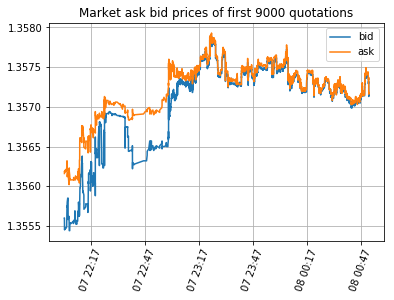

In [60]:
figure_ask_bid = plt.figure()
plt.plot(ba[0:9000])
plt.title("Market ask bid prices of first 9000 quotations")
plt.legend(["bid","ask"])
plt.xticks(rotation = 70)
plt.grid()
plt.show

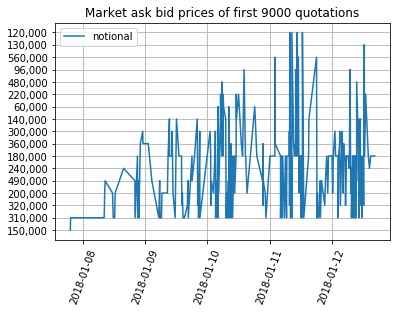

In [61]:
figure_notional = plt.figure()
plt.plot(np.array(order_timestamp),np.array(order["notional"]))
plt.title("Market ask bid prices of first 9000 quotations")
plt.legend(["notional"])
plt.xticks(rotation = 70)
plt.grid()
_ = plt.show

In [62]:
def find_pos(order_timestamp,ba):   #given order time and the trading time, find the the start pos for teach order
    out=[]
    for i,time in enumerate(order_timestamp):
        temp = ba.index.get_loc(time,method ='backfill')
        out.append(temp)
    return out

In [63]:
start_pos = find_pos(order_timestamp,ba)
h_spread =(ba["Ask"]-ba["Bid"])/2
PnL_MT =pd.DataFrame({"Excution Time":h_spread[start_pos].index,"PnL_MT(bp)":order["buy/sell"]*h_spread[start_pos].reset_index()[0]*10000})
PnL_MT.set_index(["Excution Time"], inplace=True)
PnL_MT.head()

,PnL_MT(bp)
Excution Time,
2018-01-07 22:02:03.832,2.80
2018-01-07 22:02:03.832,2.80
2018-01-08 07:38:49.708,-0.10
2018-01-08 08:10:55.233,-0.20
2018-01-08 08:19:10.599,-0.15


In [64]:
spread= ba["Ask"]-ba["Bid"]
spread = spread*10000

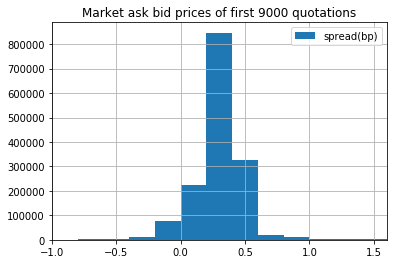

In [65]:
figure_spread = plt.figure()
plt.hist(spread,bins = 50)
plt.title("Market ask bid prices of first 9000 quotations")
plt.legend(["spread(bp)"])
plt.xlim((-1, 1.6))
plt.grid()
_ = plt.show

## 2)	Opportunistic Market Making (OMM) 
For each order, you will rest it within the Bid/Offer spread for a given amount of time awaiting for its (possible) opportunsitic execution.

In [66]:
TTE =10 # 10 secs max Time to Execution (TTE)
mid_price = (ba["Ask"]+ba["Bid"])/2
start_mid = mid_price[start_pos]
SL =0.00003 # max Stop Loss 

### First by joining “your side” of the market (ie the Bid price if you are buying, the Offer if selling) -- OMMSide
In this part, we go through every quotations after the order time in the following 10 seconds(max Time to Execution)for each order. 

Then we decide whether the order should be executed at each step following the rule below in comments.

In [12]:
bid_start = ba["Bid"][start_pos]
ask_start =ba["Ask"][start_pos]

In [13]:
def OMMside(ba,start_pos,TTE,order,start_mid,SL,PnL_MT):   
    end_time = PnL_MT.index + datetime.timedelta(seconds = TTE)
    end_pos = find_pos(end_time,ba)
    
    execution_time_side =[] 
    execution_price_side = []
    end_condition_side = []
    
    for i in np.arange(0,len(order)):
        if(order["buy/sell"][i]==1):
            for j,ask_price in enumerate(ba["Ask"][start_pos[i]:(end_pos[i]+1)]):
                #ask price at the step is smaller than or equals to bid price at the start time
                #execute the order and mark it as "end_meet_price". 
                if(ask_price == bid_start[i] or ask_price <bid_start[i]):
                    execution_price_side.append(ask_price)
                    execution_time_side.append(ba.index[start_pos[i]+j])
                    end_condition_side.append("end_meet_price")#
                    break;
                    
                #ask price at the step minus start mid price is larger than max stop loss
                #execute to aviod larger loss and mark the order as "SL triggered".
                if ((ask_price - start_mid[i])>SL):
                    execution_price_side.append(ask_price)
                    execution_time_side.append(ba.index[start_pos[i]+j])
                    end_condition_side.append("SL triggered")
                    break;
                #execute at the end and mark the order as "TTE triggered"
                if (j == ((end_pos[i]+1)-start_pos[i]-1)):
                    execution_price_side.append(ask_price)
                    execution_time_side.append(ba.index[start_pos[i]+j])
                    end_condition_side.append("TTE triggered")
        else:
            for j,bid_price in enumerate(ba["Bid"][start_pos[i]:(end_pos[i]+1)]):
                #bid price at the step is bigger than or equals to ask price at the start time
                #execute the order and mark it as "end_meet_price". 
                if(bid_price == ask_start[i] or bid_price >ask_start[i]):
                    execution_price_side.append(bid_price)
                    execution_time_side.append(ba.index[start_pos[i]+j])
                    end_condition_side.append("end_meet_price")
                    break;

                if ((start_mid[i] - bid_price)>SL):#execute to aviod larger loss and mark the order as "SL triggered".
                    execution_price_side.append(ba["Ask"][start_pos[i]+j])
                    execution_time_side.append(ba.index[start_pos[i]+j])
                    end_condition_side.append("SL triggered")
                    break;

                if (j == ((end_pos[i]+1)-start_pos[i]-1)):#execute at the end and mark the order as "TTE triggered"
                    execution_price_side.append(bid_price)
                    execution_time_side.append(ba.index[start_pos[i]+j])
                    end_condition_side.append("TTE triggered")
    return [execution_time_side,execution_price_side,end_condition_side]


In [14]:
[execution_time_side,execution_price_side,end_condition_side] = OMMside(ba,start_pos,TTE,order,start_mid,SL,PnL_MT)
PnL_OMMside = (start_mid - np.array(execution_price_side))*np.array(order["buy/sell"])
PnL_OMMside_df = pd.DataFrame({"PnL_OMMside(bp)":PnL_OMMside*10000,
                              "End condition":end_condition_side,
                               "Execution time":execution_time_side,
                               "Mid price at starting pos":start_mid,
                             "Excution price":execution_price_side})
PnL_OMMside_df.index.names =[ "Order Time"]
annex_side = PnL_OMMside_df
PnL_OMMside_df.head()

,PnL_OMMside(bp),End condition,Execution time,Mid price at starting pos,Excution price
Order Time,,,,,
2018-01-07 22:02:03.832,-2.80,SL triggered,2018-01-07 22:02:03.832,1.355880,1.35616
2018-01-07 22:02:03.832,-2.80,SL triggered,2018-01-07 22:02:03.832,1.355880,1.35616
2018-01-08 07:38:49.708,0.20,end_meet_price,2018-01-08 07:38:50.407,1.354220,1.35424
2018-01-08 08:10:55.233,0.20,end_meet_price,2018-01-08 08:11:01.082,1.354140,1.35416
2018-01-08 08:19:10.599,-0.05,SL triggered,2018-01-08 08:19:11.096,1.353785,1.35378


### Secondly by resting your order at mid market -- OMMMid
In this part, we go through every quotations after the order time in the following 10 seconds(max Time to Execution)for each order. 

Then we decide whether the order should be executed at each step following the rule in comments.


In [15]:
def OMMmid(ba,start_pos,TTE,order,start_mid,SL,PnL_MT):
    end_time = PnL_MT.index + datetime.timedelta(seconds = TTE)
    end_pos = find_pos(end_time,ba)
    
    execution_time =[] 
    execution_price = []
    end_condition = []
    
    for i in np.arange(0,len(order)):
        if(order["buy/sell"][i]==1):
            for j,ask_price in enumerate(ba["Ask"][start_pos[i]:(end_pos[i]+1)]):
                if(ask_price == start_mid[i] or ask_price <start_mid[i]):
                    #execute the order at the ask price and mark it as "end_meet_price". 
                    execution_price.append(ask_price)
                    execution_time.append(ba.index[start_pos[i]+j])
                    end_condition.append("end_meet_price")
                    break;

                if (ask_price-(start_mid[i])>SL):
                    #execute at the mid price immediately to aviod larger loss and mark the order as "SL triggered".
                    execution_price.append(mid_price[start_pos[i]+j])
                    execution_time.append(ba.index[start_pos[i]+j])
                    end_condition.append("SL triggered")
                    break;

                if (j == ((end_pos[i]+1)-start_pos[i]-1)):
                    execution_price.append(ask_price)
                    execution_time.append(ba.index[start_pos[i]+j])
                    end_condition.append("TTE triggered")
        else:
            for j,bid_price in enumerate(ba["Bid"][start_pos[i]:(end_pos[i]+1)]):
                if(bid_price == start_mid[i] or bid_price >start_mid[i]):
                    #execute the order at the bid price and mark it as "end_meet_price". 
                    execution_price.append(bid_price)
                    execution_time.append(ba.index[start_pos[i]+j])
                    end_condition.append("end_meet_price")
                    break;

                if ((start_mid[i] - bid_price)>SL):
                    #execute at the mid price immediately to aviod larger loss and mark the order as "SL triggered". 
                    execution_price.append(bid_price)
                    execution_time.append(ba.index[start_pos[i]+j])
                    end_condition.append("SL triggered")
                    break;

                if (j == ((end_pos[i]+1)-start_pos[i]-1)):
                    execution_price.append(bid_price)
                    execution_time.append(ba.index[start_pos[i]+j])
                    end_condition.append("TTE triggered")
    return [execution_time,execution_price,end_condition]



In [16]:
[execution_time,execution_price,end_condition] = OMMmid(ba,start_pos,TTE,order,start_mid,SL,PnL_MT)
PnL_OMMmid = (start_mid - np.array(execution_price))*np.array(order["buy/sell"])
PnL_OMMmid_df = pd.DataFrame({"PnL_OMMmid(bp)":PnL_OMMmid*10000,
                              "End condition":end_condition,
                              "Execution time":execution_time,
                              "Mid price at starting pos":start_mid,
                             "Excution price":execution_price})
PnL_OMMmid_df.index.names =[ "Order Time"]
annex_mid = PnL_OMMmid_df
PnL_OMMmid_df.head()

,PnL_OMMmid(bp),End condition,Execution time,Mid price at starting pos,Excution price
Order Time,,,,,
2018-01-07 22:02:03.832,0.00,SL triggered,2018-01-07 22:02:03.832,1.355880,1.35588
2018-01-07 22:02:03.832,0.00,SL triggered,2018-01-07 22:02:03.832,1.355880,1.35588
2018-01-08 07:38:49.708,-0.00,end_meet_price,2018-01-08 07:38:49.787,1.354220,1.35422
2018-01-08 08:10:55.233,0.20,end_meet_price,2018-01-08 08:11:01.082,1.354140,1.35416
2018-01-08 08:19:10.599,-0.35,SL triggered,2018-01-08 08:19:11.096,1.353785,1.35375


## 3)	Analysis
**1)For each of your 3 approaches (MT, OMMSide and OMMMid), provide a recapitulating table which will show at the minimum the average and median execution PnL for each order (taken from Mid Market), average and median time to execution, the number of times when your Stop Loss was triggered, the number of times when your order was executed on Time Limit.**

In [17]:
mean_PnL= []
mean_PnL.append(PnL_MT[ "PnL_MT(bp)" ].mean())
mean_PnL.append(PnL_OMMmid_df["PnL_OMMmid(bp)"].mean())
mean_PnL.append(PnL_OMMside_df["PnL_OMMside(bp)"].mean())
mean_execution_time=[]
mean_execution_time.append("/")
mean_execution_time.append((PnL_OMMmid_df["Execution time"]-PnL_OMMmid_df.index).mean())
mean_execution_time.append((PnL_OMMside_df["Execution time"]-PnL_OMMside_df.index).mean())


In [18]:
median_PnL = []
median_PnL.append(PnL_MT[ "PnL_MT(bp)" ].median())
median_PnL.append(PnL_OMMmid_df["PnL_OMMmid(bp)"].median())
median_PnL.append(PnL_OMMside_df["PnL_OMMside(bp)"].median())
median_execution_time=[]
median_execution_time.append("/")
median_execution_time.append((PnL_OMMmid_df["Execution time"]-PnL_OMMmid_df.index).median())
median_execution_time.append((PnL_OMMside_df["Execution time"]-PnL_OMMside_df.index).median())


In [19]:
min_PnL = []
min_PnL.append(PnL_MT[ "PnL_MT(bp)" ].min())
min_PnL.append(PnL_OMMmid_df["PnL_OMMmid(bp)"].min())
min_PnL.append(PnL_OMMside_df["PnL_OMMside(bp)"].min())
min_execution_time=[]
min_execution_time.append("/")
min_execution_time.append((PnL_OMMmid_df["Execution time"]-PnL_OMMmid_df.index).min())
min_execution_time.append((PnL_OMMside_df["Execution time"]-PnL_OMMside_df.index).min())


In [20]:
stats_ = pd.DataFrame({"mean PnL(bp)":mean_PnL,"median PnL(bp)":median_PnL,"min PnL(bp)":min_PnL,
                      "mean Execution time":mean_execution_time,"median Execution time":median_execution_time,"min Execution time":min_execution_time})
stats_.index = ["MT","OMMmid","OMMside"]
stats_

,mean PnL(bp),median PnL(bp),min PnL(bp),mean Execution time,median Execution time,min Execution time
MT,-0.020732,-0.10,-2.5,/,/,/
OMMmid,-0.150407,-0.15,-2.5,0 days 00:00:03.821918,0 days 00:00:02.041000,0 days 00:00:00
OMMside,-0.036992,-0.00,-2.8,0 days 00:00:04.680368,0 days 00:00:02.936000,0 days 00:00:00


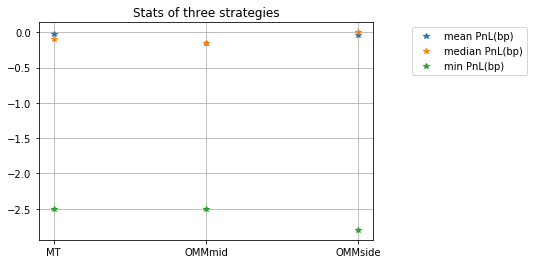

In [21]:
fig1 = plt.figure()
plt.plot(["MT","OMMmid","OMMside"],stats_[stats_.columns[0:3]],'*')
L=plt.legend(np.arange(1,4),bbox_to_anchor=(1.1, 1))
for i in range(1,4):
    L.get_texts()[i-1].set_text(stats_.columns[i-1])
plt.grid()
plt.title("Stats of three strategies")
_ = plt.show

For all approaches,we lost money because mean PnLs are negative. However OMMmid and OMMside lose less than half of the start spread.

OMMmid and OMMside strategy works **not better** than MT strategy.

###### The number of times when your Stop Loss was triggered, the number of times when your order was executed on Time Limit:

In [22]:
stop_type_number_OMMmid=PnL_OMMmid_df["End condition"].value_counts()    

In [23]:
stop_type_number_OMMside=PnL_OMMside_df["End condition"].value_counts()  

**2)Add other statistics if you wish (for extra points)**


In [24]:
sum_PnL=[]
sum_PnL.append(np.sum(PnL_MT[ "PnL_MT(bp)" ]))
sum_PnL.append(np.sum(PnL_OMMmid_df["PnL_OMMmid(bp)"]))
sum_PnL.append(np.sum(PnL_OMMside_df["PnL_OMMside(bp)"]))
stats = pd.DataFrame({"sum PnL(bp)":sum_PnL})
stats.index = ["MT","OMMmid","OMMside"]
stats

,sum PnL(bp)
MT,-7.65
OMMmid,-55.50
OMMside,-13.65


We can see that OMMside approach is the worst strategy and all strategies will loss money with all order executed if we set TTE as 10 seconds and SL as 0.00003.

**3)List in annex each trade with its PnL, time to execution and whether its SL or TTE has been triggered**  

We can see in tables in the annex at the end of this file.

### Further Analysis:

1)Show the influence of the length of TTE on the median execution PnL – present a graph

2)Each order was labelled as either DIS or MAR or SOM. These are three different apha generators. Can you find any significant differences in term of execution

### 1. **TTE v.s. mean**

In [54]:
SL = 0.005
TTE_list = [1,3,5,7,10,12,14,16,18,20,22,24,26,28,30,32,34,36,38,40,50,60,80]
mean_mid =[]
mean_side = []
for tte in TTE_list:
    #calculation of PnL_mid
    [execution_time,execution_price,end_condition] = OMMmid(ba,start_pos,tte,order,start_mid,SL,PnL_MT)
    PnL_OMMmid_temp = (start_mid - np.array(execution_price))*np.array(order["buy/sell"])*10000
    mean_mid_temp = np.mean(np.array(PnL_OMMmid_temp))
    #calculation of PnL_side
    [execution_time_side,execution_price_side,end_condition_side] = OMMside(ba,start_pos,tte,order,start_mid,SL,PnL_MT)
    PnL_OMMside_temp = (start_mid - np.array(execution_price_side))*np.array(order["buy/sell"])*10000
    mean_side_temp = np.mean(np.array(PnL_OMMside_temp))
    
    mean_mid.append(mean_mid_temp)
    mean_side.append(mean_side_temp)


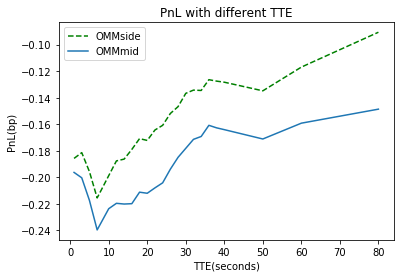

In [55]:
fig2=plt.figure()
plt.plot(TTE_list,mean_side,'g--',label="OMMside")
plt.plot(TTE_list,mean_mid,label="OMMmid")
plt.legend()
plt.title('PnL with different TTE')# give plot a title
plt.xlabel('TTE(seconds)')# make axis labels
plt.ylabel('PnL(bp)')
plt.show()

1) **Positive Margin**

As TTE increasing, the median of both strategy are going up.OMMside is a better strategy when we give a TTE that is long enough because it can earn more money than OMMmid strategy.

2) **OMMside and OMMmid have about the same sensitivity to TTE**


### 2. SL vs. PnL mean


In [77]:
SL = np.arange(0,0.0005,0.000005)
TTE_list = 50
mean_mid =[]
mean_side = []
for sl in SL:
    #calculation of PnL_mid
    [execution_time,execution_price,end_condition] = OMMmid(ba,start_pos,TTE,order,start_mid,sl,PnL_MT)
    PnL_OMMmid_temp = (start_mid - np.array(execution_price))*np.array(order["buy/sell"])*10000
    mean_mid_temp = np.mean(np.array(PnL_OMMmid_temp))
    #calculation of PnL_side
    [execution_time_side,execution_price_side,end_condition_side] = OMMside(ba,start_pos,tte,order,start_mid,sl,PnL_MT)
    PnL_OMMside_temp = (start_mid - np.array(execution_price_side))*np.array(order["buy/sell"])*10000
    mean_side_temp = np.mean(np.array(PnL_OMMside_temp))
    
    mean_mid.append(mean_mid_temp)
    mean_side.append(mean_side_temp)

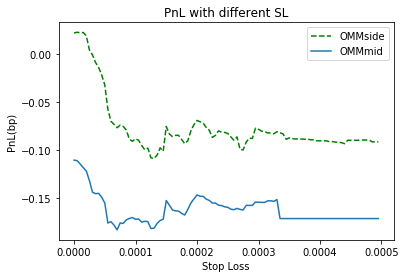

In [78]:
fig4=plt.figure()
plt.plot(SL,mean_side,'g--',label="OMMside")
plt.plot(SL,mean_mid,label="OMMmid")
plt.legend()
plt.title('PnL with different SL')# give plot a title
plt.xlabel('Stop Loss')# make axis labels
plt.ylabel('PnL(bp)')
plt.show()

###  3.Anlysis about different Alphas

We can see from the conclusion above, 50 seconds for TTE might be a safe choice.

In [89]:
TTE = 50
SL = 0.00002

In [90]:
[execution_time_side,execution_price_side,end_condition_side] = OMMside(ba,start_pos,TTE,order,start_mid,SL,PnL_MT)
PnL_OMMside = (start_mid - np.array(execution_price_side))*np.array(order["buy/sell"])
PnL_OMMside =pd.DataFrame(PnL_OMMside*10000)
PnL_OMMside.columns = ["PnL_OMMside(bp)"]
PnL_OMMside.index.names =[ "Order Time"]
PnL_OMMside_df = pd.DataFrame({"PnL_OMMside(bp)":PnL_OMMside["PnL_OMMside(bp)"],
                              "End condition":end_condition_side,"Execution time":execution_time_side,
                               "Mid price at starting pos":start_mid,
                             "Excution price":execution_price_side,
                              "Alpha":np.array(order["alpha"])})
PnL_OMMside_df.head()

,PnL_OMMside(bp),End condition,Execution time,Mid price at starting pos,Excution price,Alpha
Order Time,,,,,,
2018-01-07 22:02:03.832,-2.80,SL triggered,2018-01-07 22:02:03.832,1.355880,1.35616,SOM
2018-01-07 22:02:03.832,-2.80,SL triggered,2018-01-07 22:02:03.832,1.355880,1.35616,SOM
2018-01-08 07:38:49.708,0.20,end_meet_price,2018-01-08 07:38:50.407,1.354220,1.35424,SOM
2018-01-08 08:10:55.233,0.20,SL triggered,2018-01-08 08:10:55.233,1.354140,1.35416,SOM
2018-01-08 08:19:10.599,0.15,SL triggered,2018-01-08 08:19:10.619,1.353785,1.35380,SOM


In [91]:
median_side = PnL_OMMside_df[["PnL_OMMside(bp)","Alpha"]].groupby(['Alpha']).median()
mean_side = PnL_OMMside_df[["PnL_OMMside(bp)","Alpha"]].groupby(['Alpha']).mean()

In [92]:
[execution_time,execution_price,end_condition] = OMMmid(ba,start_pos,TTE,order,start_mid,SL,PnL_MT)
PnL_OMMmid = (start_mid - np.array(execution_price))*np.array(order["buy/sell"])
PnL_OMMmid =pd.DataFrame(PnL_OMMmid*10000)
PnL_OMMmid.columns = ["PnL_OMMmid(bp)"]
PnL_OMMmid.index.names =[ "Order Time"]
PnL_OMMmid_df = pd.DataFrame({"PnL_OMMmid(bp)":PnL_OMMmid["PnL_OMMmid(bp)"],
                              "End condition":end_condition,"Execution time":execution_time,
                               "Mid price at starting pos":start_mid,
                             "Excution price":execution_price,
                              "Alpha":np.array(order["alpha"])})
PnL_OMMmid_df.head()

,PnL_OMMmid(bp),End condition,Execution time,Mid price at starting pos,Excution price,Alpha
Order Time,,,,,,
2018-01-07 22:02:03.832,0.00,SL triggered,2018-01-07 22:02:03.832,1.355880,1.35588,SOM
2018-01-07 22:02:03.832,0.00,SL triggered,2018-01-07 22:02:03.832,1.355880,1.35588,SOM
2018-01-08 07:38:49.708,-0.00,end_meet_price,2018-01-08 07:38:49.787,1.354220,1.35422,SOM
2018-01-08 08:10:55.233,-0.20,SL triggered,2018-01-08 08:10:55.233,1.354140,1.35412,SOM
2018-01-08 08:19:10.599,-0.25,SL triggered,2018-01-08 08:19:10.619,1.353785,1.35376,SOM


In [93]:
median_mid = PnL_OMMmid_df[["PnL_OMMmid(bp)","Alpha"]].groupby(['Alpha']).median()
mean_mid = PnL_OMMmid_df[["PnL_OMMmid(bp)","Alpha"]].groupby(['Alpha']).mean()
mean_mid

,PnL_OMMmid(bp)
Alpha,
DIS,-0.117500
MAR,-0.083051
SOM,-0.132000


In [94]:
alpha_=pd.DataFrame({"PnL_OMMside(bp) median":median_side["PnL_OMMside(bp)"],"PnL_OMMside(bp) mean":mean_side["PnL_OMMside(bp)"],
              "PnL_OMMmid(bp) median":median_mid["PnL_OMMmid(bp)"],"PnL_OMMmid(bp) mean":mean_mid["PnL_OMMmid(bp)"]})
alpha_

,PnL_OMMside(bp) median,PnL_OMMside(bp) mean,PnL_OMMmid(bp) median,PnL_OMMmid(bp) mean
Alpha,,,,
DIS,0.05,-0.026667,-0.10,-0.117500
MAR,0.05,-0.012712,-0.05,-0.083051
SOM,0.15,0.035600,-0.10,-0.132000


<function matplotlib.pyplot.show(*args, **kw)>

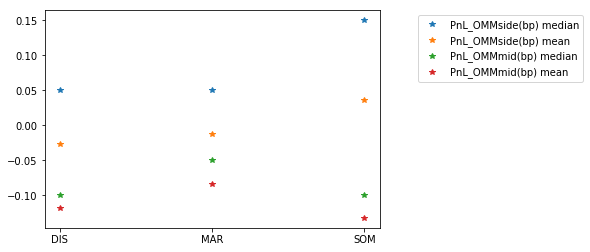

In [95]:
fig3 = plt.figure()
plt.plot(["DIS","MAR","SOM"],alpha_,'*')
L=plt.legend(np.arange(1,5),bbox_to_anchor=(1.1, 1))
for i in range(1,5):
    L.get_texts()[i-1].set_text(alpha_.columns[i-1])
plt.show

We can find from the graph above that:

1) For all of these three strategies, OMMside is a better choice with TTE = 40 and SL = 0.01

2) To rank these three alpha strategies, we can say that `MAR>SOM>DIS`. However, the difference is not that huge.

# 6. Annex

In [34]:
annex_side[:]

,PnL_OMMside(bp),End condition,Execution time,Mid price at starting pos,Excution price
Order Time,,,,,
2018-01-07 22:02:03.832,-2.80,SL triggered,2018-01-07 22:02:03.832,1.355880,1.35616
2018-01-07 22:02:03.832,-2.80,SL triggered,2018-01-07 22:02:03.832,1.355880,1.35616
2018-01-08 07:38:49.708,0.20,end_meet_price,2018-01-08 07:38:50.407,1.354220,1.35424
2018-01-08 08:10:55.233,0.20,end_meet_price,2018-01-08 08:11:01.082,1.354140,1.35416
2018-01-08 08:19:10.599,-0.05,SL triggered,2018-01-08 08:19:11.096,1.353785,1.35378
2018-01-08 08:23:16.738,-0.10,TTE triggered,2018-01-08 08:23:29.753,1.353530,1.35352
2018-01-08 08:34:40.821,0.05,end_meet_price,2018-01-08 08:34:40.878,1.353825,1.35383
2018-01-08 11:25:14.548,-0.35,SL triggered,2018-01-08 11:25:16.331,1.354385,1.35442
2018-01-08 11:42:08.435,-0.35,SL triggered,2018-01-08 11:42:08.527,1.354385,1.35442


In [35]:
annex_mid[:]

,PnL_OMMmid(bp),End condition,Execution time,Mid price at starting pos,Excution price
Order Time,,,,,
2018-01-07 22:02:03.832,0.000000e+00,SL triggered,2018-01-07 22:02:03.832,1.355880,1.355880
2018-01-07 22:02:03.832,0.000000e+00,SL triggered,2018-01-07 22:02:03.832,1.355880,1.355880
2018-01-08 07:38:49.708,-0.000000e+00,end_meet_price,2018-01-08 07:38:49.787,1.354220,1.354220
2018-01-08 08:10:55.233,2.000000e-01,end_meet_price,2018-01-08 08:11:01.082,1.354140,1.354160
2018-01-08 08:19:10.599,-3.500000e-01,SL triggered,2018-01-08 08:19:11.096,1.353785,1.353750
2018-01-08 08:23:16.738,-1.000000e-01,TTE triggered,2018-01-08 08:23:29.753,1.353530,1.353520
2018-01-08 08:34:40.821,5.000000e-02,end_meet_price,2018-01-08 08:34:40.878,1.353825,1.353830
2018-01-08 11:25:14.548,-1.000000e-01,SL triggered,2018-01-08 11:25:16.331,1.354385,1.354395
2018-01-08 11:42:08.435,-1.000000e-01,SL triggered,2018-01-08 11:42:08.527,1.354385,1.354395
